In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = "C:/Users/hosei/Documents/DataSets/GTSRB"
train_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Train/"
test_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Test/"
meta_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Meta/"

meta_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Meta.csv')
train_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Train.csv')
test_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Test.csv')

In [3]:
#hyper parametes
num_of_classes = len(os.listdir(train_path))
height = 30
width = 30
channels = 3
n_inputs = height * width * num_of_classes
num_epochs = 2
batch_size = 32
learning_rate = 0.001

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

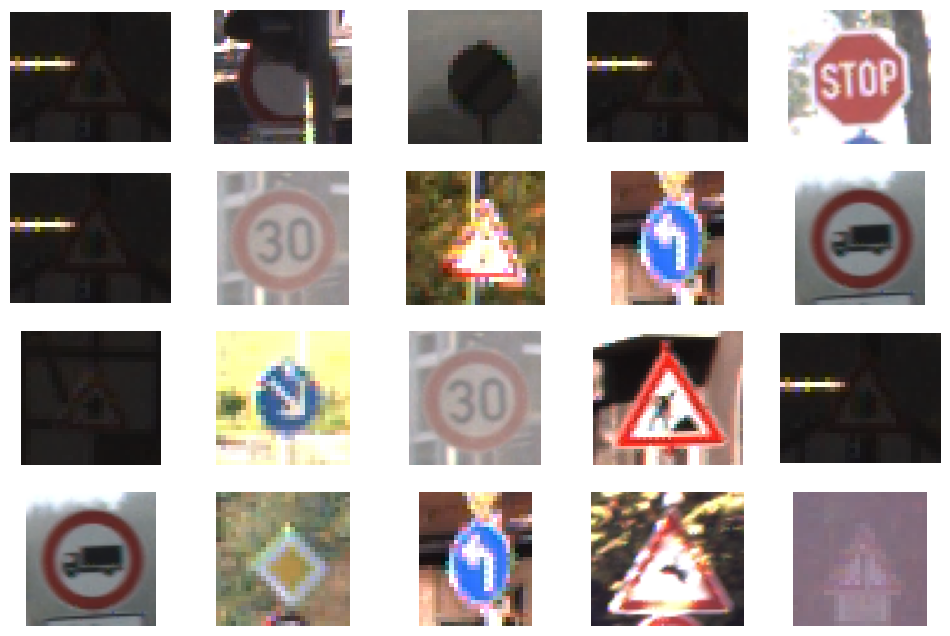

In [5]:

#data Visualation
folder_names = [os.path.join(train_path, str(i)) for i in random.choices(range(43), k=20)] 
file_names = [os.path.join(fldr, os.listdir(fldr)[0]) for fldr in folder_names]

fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, image_path in enumerate(file_names):
    image = Image.open(image_path)
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.show()

In [6]:
# Transforming the Data ToTensor and Normalize it 

transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((28,28)),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
class GTSR_DataSet(Dataset):
    def __init__(self, df, root_dir,transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        image_path = os.path.join(self.root_dir,self.df.iloc[index,7])  #the column of paths in dataframe is 7
        image = Image.open(image_path)
        y_class = torch.tensor(self.df.iloc[index, 6]) #the column of ClsassId in daraframe is 6
        
        if self.transform:
            image = self.transform(image)
            return (image, y_class)

In [7]:
training_set = GTSR_DataSet(train_df,data_dir,transform=transforms)
test_set = GTSR_DataSet(test_df,data_dir,transform=transforms)

In [8]:
train_loader = DataLoader(dataset = training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size=batch_size, shuffle=False)

dataloaders = {'training':train_loader,'testing':test_loader}
dataset_sizes = {'training':len(train_loader.dataset),'testing':len(test_loader.dataset)}
print(dataset_sizes)

{'training': 39209, 'testing': 12630}


In [9]:
#creating the model
class GTRSB_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(GTRSB_Model, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)

        # self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        # self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        # self.batchnorm3 = nn.BatchNorm2d(1024)
        # self.maxpool3 = nn.AdaptiveMaxPool2d(512)

        
        self.l1 = nn.Linear(12544,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_size)




    def forward(self,input):
        conv = self.conv1(input)
        conv = self.conv2(conv)
        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)
        conv = self.conv3(maxpool)
        conv = self.conv4(conv)
        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        # conv = self.conv5(maxpool)
        # conv = self.conv6(conv)
        # batchnorm = self.relu(self.batchnorm3(conv))
        # maxpool = self.maxpool3(batchnorm)
    

              
        flatten = self.flatten(maxpool)
        
        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)
        
    
        return output

In [10]:

input_size = 3*28*28
output_size = 43
model = GTRSB_Model(input_size=input_size, output_size=output_size)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
for epoch in range(len(train_loader)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images
            labels = labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            n_samples +=labels.shape[0]
            n_correct +=(predictions == labels).sum().item()
        acc = 100.0 * (n_correct / n_samples)
        print(f'accuracy = {acc}')

c:\Users\hosei\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch 1 / 2, step 10, loss = 3.5520365238189697
epoch 1 / 2, step 20, loss = 3.4658379554748535
epoch 1 / 2, step 30, loss = 3.648681879043579
epoch 1 / 2, step 40, loss = 3.33900785446167
epoch 1 / 2, step 50, loss = 3.470092296600342
epoch 1 / 2, step 60, loss = 3.3481028079986572
epoch 1 / 2, step 70, loss = 3.2261390686035156
epoch 1 / 2, step 80, loss = 2.9014835357666016
epoch 1 / 2, step 90, loss = 3.3262534141540527
epoch 1 / 2, step 100, loss = 3.048064708709717
epoch 1 / 2, step 110, loss = 2.6908955574035645
epoch 1 / 2, step 120, loss = 2.61950421333313
epoch 1 / 2, step 130, loss = 2.5029053688049316
epoch 1 / 2, step 140, loss = 2.0441718101501465
epoch 1 / 2, step 150, loss = 2.097074031829834
epoch 1 / 2, step 160, loss = 2.0551812648773193
epoch 1 / 2, step 170, loss = 2.0425572395324707
epoch 1 / 2, step 180, loss = 1.889260172843933
epoch 1 / 2, step 190, loss = 2.009516716003418
epoch 1 / 2, step 200, loss = 1.9647409915924072
epoch 1 / 2, step 210, loss = 1.7284352